### Imports

In [1]:
import sys
mypath = "/home/basia/Documents/spectroscopy/magnetstein"
sys.path.insert(0, mypath)

In [2]:
import numpy as np
import pandas as pd
import os
from masserstein import NMRSpectrum, estimate_proportions
import matplotlib.pyplot as plt
import pulp
import pickle

### Data

In [3]:
experiment_name = 'Saccharose hydrolysis'

In [4]:
mixture_paths = {'Saccharose hydrolysis': '../data/saccharose_hydrolysis/preprocessed_mixture.csv',
                'PMG 284 monitoring': '../data/PMG_284/preprocessed_mixture.csv',
                'PMG 287 monitoring': '../data/PMG_287/preprocessed_mixture_cut_to_regions.csv'
                }

reagents_paths = {'Saccharose hydrolysis': ['../data/saccharose_hydrolysis/preprocessed_saccharose.csv', 
                                            '../data/saccharose_hydrolysis/preprocessed_alpha_glucose.csv',
                                            '../data/saccharose_hydrolysis/preprocessed_beta_glucose.csv',
                                            '../data/saccharose_hydrolysis/preprocessed_fructose.csv'],
                'PMG 284 monitoring': ['../data/PMG_284/preprocessed_pentene.csv',
                                      '../data/PMG_284/preprocessed_triethylsilane.csv',
                                      '../data/PMG_284/preprocessed_product.csv'],
                'PMG 287 monitoring': ['../data/PMG_287/preprocessed_hexene.csv',
                                      '../data/PMG_287/preprocessed_triethylsilane.csv',
                                      '../data/PMG_287/preprocessed_product.csv']}

mixture_separators = {'Saccharose hydrolysis': '\t',
                'PMG 284 monitoring': '\t',
                'PMG 287 monitoring': '\t'
                }

reagents_separators = {'Saccharose hydrolysis': '\t',
                'PMG 284 monitoring': '\t',
                'PMG 287 monitoring': '\t'
                }

results_paths = {'Saccharose hydrolysis': '../results/saccharose_hydrolysis/',
                'PMG 284 monitoring': '../results/PMG_284/',
                'PMG 287 monitoring': '../results/PMG_287/cut_spectrum_of_mixture/'}

#### Mixture in time

In [5]:
mixture_time_data = pd.read_csv(mixture_paths[experiment_name], sep = mixture_separators[experiment_name])


In [6]:
mixture_time_data = pd.read_csv(mixture_paths[experiment_name], sep = mixture_separators[experiment_name])
if experiment_name == 'Saccharose hydrolysis':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)
elif experiment_name == 'PMG 284 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)
elif experiment_name == 'PMG 287 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)

In [7]:
names = ['ppm'] + ['t' + str(nb) for nb in range(1, mixture_time_data.shape[1])]

In [8]:
mixture_time_data.columns = names

In [9]:
def load_spectrum(mixture_time_data, moment_of_time):
    ppm = mixture_time_data['ppm']
    intensity = mixture_time_data['t'+str(moment_of_time)]
    sp = NMRSpectrum(confs = list(zip(ppm, intensity)))
    sp.trim_negative_intensities()
    sp.normalize()
    return sp

#### Reagents

In [10]:
reagents_spectra = []
for reagent in reagents_paths[experiment_name]:
    reag = pd.read_csv(reagent, sep=reagents_separators[experiment_name], header=None).iloc[:,:2]
    reagents_spectra.append(reag)

In [11]:
reagents_spectra2 = []
for reag in reagents_spectra:
    ppm = reag.iloc[:,0]
    ints = reag.iloc[:,1]
    sp = NMRSpectrum(confs = list(zip(ppm, ints)))
    reagents_spectra2.append(sp)
reagents_spectra = reagents_spectra2
del(reagents_spectra2)

In [12]:
for sp in reagents_spectra:
    sp.trim_negative_intensities()
    sp.normalize()

In [13]:
%matplotlib notebook

In [14]:
reagents_spectra

<IPython.core.display.Javascript object>


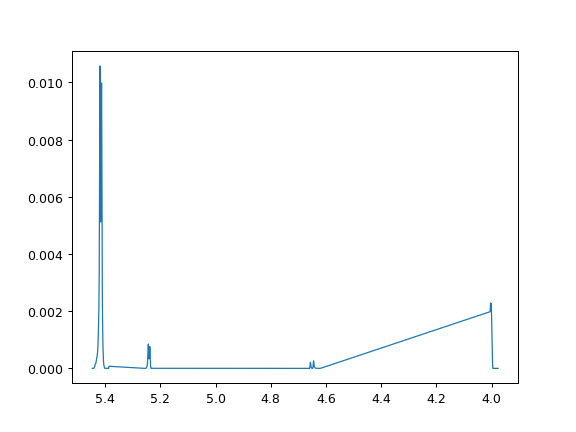

In [15]:
plt.gca().invert_xaxis()
NMRSpectrum.plot(load_spectrum(mixture_time_data, 30), profile=True)
#NMRSpectrum.plot_all(reagents_spectra + [load_spectrum(mixture_time_data, 100)], profile=True)

### Estimation

In [17]:
kappa = 0.25
kappa_th = 0.25
#0.25, 0.5

In [18]:
proportions_in_times = []
noise_proportions_in_times = []
noise = []
noise_in_components = []

for i in range(1, mixture_time_data.shape[1]):
    print('This is timepoint '+str(i)+'.\n')
    mix = load_spectrum(mixture_time_data, i)
    mix.trim_negative_intensities()
    mix.normalize()
    estimation = estimate_proportions(mix, reagents_spectra, what_to_compare='area', 
                                      solver=pulp.GUROBI(msg=False),
                                     MTD=kappa, MTD_th=kappa_th)
    proportions_in_times.append(estimation['proportions'])
    noise_proportions_in_times.append(estimation['proportion_of_noise_in_components'])
    noise.append(estimation['noise'])
    noise_in_components.append(estimation['noise_in_components'])
#     if i>1:
#         assert estimation['common_horizontal_axis'] == common_horizontal_axis
    common_horizontal_axis = estimation['common_horizontal_axis']
    
    print('Proportions:\n')
    print(estimation['proportions'])
    print('\n')
    print('Proportion_of_noise_in_components:\n')
    print(estimation['proportion_of_noise_in_components'])
    print('\n')

This is timepoint 1.

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
Proportions:

[0.9959509450410992, 0.0021461670606236255, 0.0001906533709470861, 0.0017122345273306995]


Proportion_of_noise_in_components:

0.0


This is timepoint 2.



/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Proportions:

[0.9898961699363154, 0.005200429766344078, 0.00028767340683292575, 0.004615726890507503]


Proportion_of_noise_in_components:

0.0


This is timepoint 3.

Proportions:

[0.9833093853954805, 0.007920556669100442, 0.0004456343425540367, 0.008324423592865497]


Proportion_of_noise_in_components:

0.0


This is timepoint 4.

Proportions:

[0.9772952597251359, 0.010142146983611535, 0.0006593078083515182, 0.011903285482900632]


Proportion_of_noise_in_components:

0.0


This is timepoint 5.

Proportions:

[0.9698286378022873, 0.012246762994316061, 0.0009093396150192768, 0.017015259588376866]


Proportion_of_noise_in_components:

0.0


This is timepoint 6.

Proportions:

[0.9643064402630505, 0.01386293535567306, 0.0012380702685014775, 0.020592554112774875]


Proportion_of_noise_in_components:

0.0


This is timepoint 7.

Proportions:

[0.9568855600759012, 0.01583729075835959, 0.0016669219478613355, 0.025610227217878395]


Proportion_of_noise_in_components:

0.0


This is timepoi

Proportions:

[0.6347126279318581, 0.082282919280202, 0.023365144052367736, 0.25963930873557184]


Proportion_of_noise_in_components:

0.0


This is timepoint 53.

Proportions:

[0.6407829954127361, 0.08210631943291008, 0.023829942828356373, 0.25328074232599745]


Proportion_of_noise_in_components:

0.0


This is timepoint 54.

Proportions:

[0.6473080569555112, 0.08211277565695846, 0.024823313451650134, 0.24575585393587948]


Proportion_of_noise_in_components:

0.0


This is timepoint 55.

Proportions:

[0.604812545019063, 0.08219044180826515, 0.02534538277664009, 0.2876516303960325]


Proportion_of_noise_in_components:

0.0


This is timepoint 56.

Proportions:

[0.6229757536506214, 0.0808597293740229, 0.023715616587476646, 0.2724489003878796]


Proportion_of_noise_in_components:

0.0


This is timepoint 57.

Proportions:

[0.6065970565018886, 0.08698462699369881, 0.026041739577621438, 0.28037657692679147]


Proportion_of_noise_in_components:

0.0


This is timepoint 58.

Proportions

Proportions:

[0.2951252489592704, 0.11920215564381267, 0.0400017082422095, 0.5456708871547068]


Proportion_of_noise_in_components:

0.0


This is timepoint 103.

Proportions:

[0.28604408785230834, 0.11683001055050965, 0.03898111602095542, 0.5581447855762266]


Proportion_of_noise_in_components:

0.0




In [19]:
len(proportions_in_times)

103

<IPython.core.display.Javascript object>


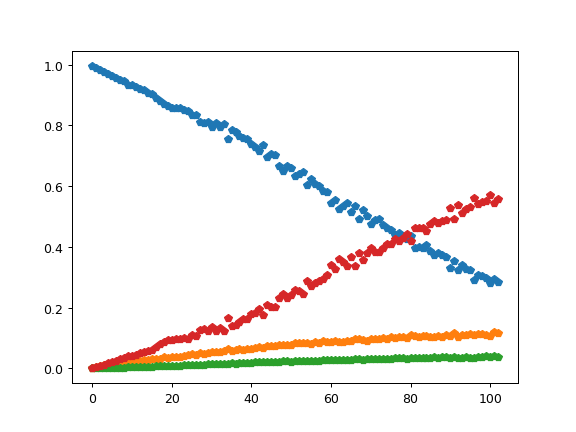

In [21]:
for i in range(len(reagents_spectra)):
    plt.plot(range(len(proportions_in_times)), [prop[i] for prop in proportions_in_times], 'p')

In [22]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(proportions_in_times, f)

In [23]:
with open(results_paths[experiment_name]+'noise_proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise_proportions_in_times, f)

In [24]:
with open(results_paths[experiment_name]+'common_horizontal_axis_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(common_horizontal_axis, f)

In [25]:
with open(results_paths[experiment_name]+'noise_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise, f)

In [26]:
with open(results_paths[experiment_name]+'noise_in_components_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise_in_components, f)